In [1]:
import ast
import subprocess
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


In [ ]:
def _buildCmd(smi_from, myMMPsDB, property=None, radius=-1):
    if property is None:
        gen_type = "generate"
        commandLine = ["mmpdb", f"{gen_type}", "--smiles", f"{smi_from}", f"{myMMPsDB}", "--radius", f"{radius}"]
        if radius in [0, 1, 2, 3, 4, 5]:
            commandLine.append("--radius")
            commandLine.append(f"{radius}")
    else:
        gen_type = "transform"
        commandLine = ["mmpdb", f"{gen_type}", "--smiles", f"{smi_from}", f"{myMMPsDB}", "-r", f"{radius}"]
        ##
        proplist = property.split(',')
        for prop in proplist:
            commandLine.append("--property")
            commandLine.append(f"{property}")
        ##
        if radius in [0, 1, 2, 3, 4, 5]:
            commandLine.append("-r")
            commandLine.append(f"{radius}")

    print(f'\tCommands:', ' '.join(commandLine))
    return commandLine

## --------------------------------------------------
def _runCmd(commandLine):
    dataDict = {}
    try:
        process = subprocess.Popen(commandLine, stdout=subprocess.PIPE)
        output, error = process.communicate()
        list_output = output.decode().split('\n')
    except Exception as e:
        print(f'\tCannot decode the output. Error msg: {e}')
    else:
        for i in range(len(list_output)):
            if list_output[i] != '':
                list_line = list_output[i].split('\t')
                if i == 0:
                    list_colNames = list_line
                    num_cols = len(list_colNames)
                else:
                    dataDict[i] = {}

                    if len(list_line) != num_cols:
                        print(f"Error, This row {i} has different number of cols to the header row, {list_output[i]}")
                    else:
                        for colid in range(len(list_colNames)):
                            col = list_colNames[colid]
                            dataDict[i][col] = list_line[colid]
    return dataDict

## --------------------------------------------------
def CleanResults(smi_from, myMMPsDB, property=None, radius=-1):
    ##
    commandLine = _buildCmd(smi_from=smi_from, myMMPsDB=myMMPsDB, property=property, radius=radius)
    dataDict = _runCmd(commandLine)
    dataTable = pd.DataFrame.from_dict(dataDict).T

    ##
    if property is None:
        renameCols = {
            'start': 'mol_start', 
            'final': 'mol_gen', 
            'constant': 'fragment_constant', 
            'from_smiles': 'fragment_from', 
            'to_smiles': 'fragment_to', 
            'r': 'radius', 
            'Rule_Info': 'Rule_Info'}
        dataTable["Rule_Info"] = dataTable["pair_from_id"] + '=>' + dataTable["pair_to_id"] + ' (N_Pairs=' + dataTable["#pairs"] + ')'

    else:
        renameCols = {
            'start': 'mol_start',
            'SMILES': 'mol_gen',
            'constant': 'fragment_constant',
            f'{property}_from_smiles': 'fragment_from', 
            f'{property}_to_smiles': 'fragment_to', 
            f'{property}_radius': 'radius', 
            f'{property}_avg': f'{property}_avg',
            'Rule_Info': 'Rule_Info',}
            
        dataTable["start"] = smi_from
        dataTable["constant"] = np.nan
        dataTable["Rule_Info"] = 'Rule_env_id: ' + dataTable[f"{property}_rule_environment_id"] + ' (N_Pairs=' + dataTable["EstFa_Rat_count"] + ')'
    ##
    dataTable_gen = dataTable[renameCols.keys()].rename(columns=renameCols)
    print(f"\tGenerate {dataTable_gen.shape[0]} analoges")
    return dataTable_gen

## --------------------------------------------------


In [ ]:
myMMPsDB = "./Compounds_All.mmpdb"
smi_from = "c1cccnc1O"
radius = 0

Unable to fragment --smiles 'CCN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1': too many rotatable bonds


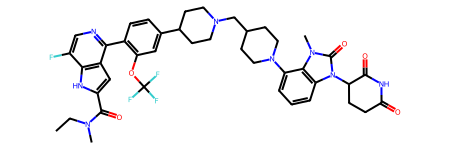

In [4]:
!mmpdb transform  --smiles 'CCN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1' ./Compounds_All.mmpdb --property EstFa_Rat
Chem.MolFromSmiles('CCN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1')

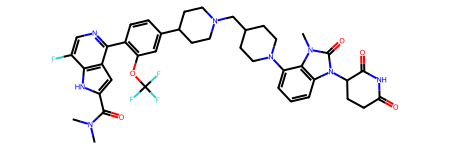

In [7]:
test_smi = 'CN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1'
Chem.MolFromSmiles(test_smi)

In [9]:
from rdkit import Chem

# Define the molecule and the substructure
mol = Chem.MolFromSmiles('CCOCC')
substructure = Chem.MolFromSmiles('CC')

# Find matches
matches = mol.GetSubstructMatches(substructure)

# Print the matches
print(matches)


((0, 1), (3, 4))


In [11]:
matches[0]

(0, 1)

In [18]:
from mmpdblib import dbutils
db = dbutils.open_database("./Compounds_All.mmpdb")
from mmpdblib import analysis_algorithms
dataset = db.get_dataset()
predict_tool = analysis_algorithms.get_predict_tool(dataset)
predict_tool.fragment_filter.max_rotatable_bonds

10

In [19]:
from mmpdblib import dbutils
db = dbutils.open_database("../ADMETox/results/Compounds_All.mmpdb")
from mmpdblib import analysis_algorithms
dataset = db.get_dataset()
predict_tool = analysis_algorithms.get_predict_tool(dataset)
predict_tool.fragment_filter.max_rotatable_bonds

10

In [20]:
from mmpdblib import dbutils
db = dbutils.open_database("../Test_1_hERG_2024Jun12/results/hERG_All_1956_2024Jun14.mmpdb")
from mmpdblib import analysis_algorithms
dataset = db.get_dataset()

from mmpdblib import analysis_algorithms
from mmpdblib.analysis_algorithms import predict_tool
predict_tool = get_predict_tool(dataset)
predict_tool.fragment_filter.max_rotatable_bonds

10

In [ ]:
from mmpdblib.analysis_algorithms import predict_tool

predict_tool = predict_tool(dataset=dataset,
                            property_name_to_id=property_name_to_id,
                            fragment_filter=fragment_filter,
                            fragment_options=default_fragment_options,
                            rule_selection_function=default_rule_selection_function)


predict_tool = analysis_algorithms.get_predict_tool(dataset)

In [21]:
cursor = dataset.get_cursor()
fragment_options = dataset.get_fragment_options(cursor)
fragment_filter = fragment_options.get_fragment_filter()
fragment_filter

NameError: name 'cursor' is not defined

In [ ]:
## get_predict_tool() ==> 

In [ ]:
db = dbutils.open_database("e.mmpdb")
dataset = db.get_dataset()
predict_tool = get_predict_tool(dataset)


mol =  Chem.MolFromSmiles(smiles)
errmsg = PredictTool.fragment_filter.apply_filters(mol)

# max_rotatable_bonds = self.max_rotatable_bonds
#         if max_rotatable_bonds is not None:
#             # The maxMatches (in RDKit at least up to early 2016) specifies
#             # the number of non-unique matches. After those N are found, they
#             # are filtered to remove duplicates. It's possible that up to
#             # 1/2 of the bonds will be removed, so the limit must be twice
#             # the max requested, plus 1
#             matches = mol.GetSubstructMatches(
#                 self.rotatable_pattern,
#                 uniquify=True,
#                 maxMatches=max_rotatable_bonds * 2 + 1,
#             )
#             if len(matches) > max_rotatable_bonds:
#                 return "too many rotatable bonds

In [6]:
!mmpdb generate --smiles 'CN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1' ./Compounds_All.mmpdb

start	constant	from_smiles	to_smiles	r	pseudosmiles	final	heavies_diff	#pairs	pair_from_id	pair_from_smiles	pair_to_id	pair_to_smiles
CN(C)C(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	*N(C)C(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	[*:1]C	[*:1][H]	0	[*:1](~*)	CNC(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	-1	1018	KT-0004822	CC#Cc1cc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)ccc1C	KT-0004096	C#Cc1cc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)ccc1C
CN(C)C(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	*N(C)C(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	[*:1]C	[*:1]F	0	[*:1](~*)	CN(F)C(=O)c1cc2c(-c3ccc(C4CCN(CC5CCN(c6cccc7c6n(C)c(=O)n7C6CCC(=O)NC6=O)CC5)CC4)cc3OC(F)(F)F)ncc(F)c2[nH]1	0	165	KT-0004772	CN(C[C@H]1CC[C@H](n

In [ ]:
test_smi = 'CN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1'
Chem.MolFromSmiles(test_smi)

In [ ]:
!mmpdb generate --smiles 'CN(C)C(=O)C1=CC2=C(N1)C(F)=CN=C2C1=C(OC(F)(F)F)C=C(C2CCN(CC3CCN(C4=CC=CC5=C4N(C)C(=O)N5C4CCC(=O)NC4=O)CC3)CC2)C=C1' ./Compounds_All.mmpdb

In [ ]:
# !mmpdb transform --smiles 'c1cccnc1O' "./Compounds_All.mmpdb" --property EstFa_Rat --property hERG_mixedIC50 -r 0

In [ ]:
property = "EstFa_Rat"
CleanResults(smi_from=smi_from, myMMPsDB=myMMPsDB, property=property, radius=radius)

In [ ]:
property = None
CleanResults(smi_from=smi_from, myMMPsDB=myMMPsDB, property=property, radius=radius)

In [ ]:
'''
mmpdb generate
Options:
  --smiles SMILES                 The full molecule to process
  --constant SMILES               The constant fragment SMILES
  --query, --variable SMILES      The query/variable fragment SMILES
  --subqueries / --no-subqueries  If specified, also generate and include subfragments of the query fragment
  --radius [0|1|2|3|4|5]          Fingerprint environment radius (default: 0)
  --min-pairs N                   Only consider rules with at least N matched molecular pairs
  --select-pair [first|better|quadratic|min|random]
                                  If 'first' (fastest), select a representative pair arbitrarily. 
                                  If 'quadratic' or 'better', minimize sum of num_heavies**2. 
                                  If 'min', use the minimum num_heavies for either side. 
                                  If 'random', select one at random.
  -o, --output FILENAME
  --columns STR1,STR2,...         A comma-separated list of output fields (see below for the default)
  --headers STR1,STR2,...         A comma-separated list of column headers (default uses --fields)
  --no-header                     Use --no-header to exclude the column headers in the output
  -j, --num-jobs INTEGER RANGE    Number of processes to use when welding SMILES (0 means use all available CPUs) [x>=0]
  --chunksize INTEGER RANGE       Number of SMILES to process in each multiprocessing work unit (default: 100) [x>=1]
  --in-memory                     Load the SQLite database into memory before use
  --explain                       Explain the steps in the generation process
  --help                          Show this message and exit.
'''

In [ ]:
'''
mmpdb transform
Options:
  -s, --smiles TEXT               The base structure to transform  [required]
  --min-variable-size N           Require at least N atoms in the variable fragment (default: 0)
  --max-variable-size N           Allow at most N atoms in the variable fragment (default: 9999)
  --min-constant-size N           Require at least N atoms in the constant fragment (default: 0)
  -r, --min-radius [0|1|2|3|4|5]  Fingerprint radius (default: 0)
  --min-pairs N                   Require at least N pairs in the transformation to report a product (default: 0)
  -S, --substructure SMARTS       Require the substructure pattern in the product
  --no-properties                 Don't use any properties
  -p, --property NAME             Property to use (may be specified multiple times)
  --rule-selection-cutoffs LIST   Evaluate rule environments with the given minimum pair count. If multiple counts are
                                  given, consider them in turn until there is a selected environment. (default: '10,5,0')
  --score EXPR                    Use to break ties when multiple rules produce the same SMILES
  --where EXPR                    Select only rules for which the expression is true
  -j, --jobs N                    Number of jobs to run in parallel (default: 1)
  --explain                       Explain each of the steps in the transformation process
  -o, --output FILENAME           Save the output to FILENAME (default=stdout)
  --times                         Report timing information for each step
  --help                          Show this message and exit.
'''